100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 46.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 33.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.01MB/s]


Epoch [1/20], D Loss: 0.6109, G Loss: 3.6564
Epoch [2/20], D Loss: 0.4878, G Loss: 2.5819
Epoch [3/20], D Loss: 0.6994, G Loss: 2.0009
Epoch [4/20], D Loss: 0.3510, G Loss: 3.2993
Epoch [5/20], D Loss: 0.6877, G Loss: 2.2381
Epoch [6/20], D Loss: 0.1431, G Loss: 4.7472
Epoch [7/20], D Loss: 0.2329, G Loss: 2.8918
Epoch [8/20], D Loss: 0.3211, G Loss: 2.5775
Epoch [9/20], D Loss: 0.6926, G Loss: 2.6626
Epoch [10/20], D Loss: 0.3687, G Loss: 3.4438
Epoch [11/20], D Loss: 0.6522, G Loss: 3.3329
Epoch [12/20], D Loss: 0.7607, G Loss: 1.9052
Epoch [13/20], D Loss: 0.6084, G Loss: 2.0007
Epoch [14/20], D Loss: 0.4881, G Loss: 2.6567
Epoch [15/20], D Loss: 0.5614, G Loss: 3.4038
Epoch [16/20], D Loss: 0.7656, G Loss: 2.5847
Epoch [17/20], D Loss: 0.7685, G Loss: 2.2587
Epoch [18/20], D Loss: 0.4920, G Loss: 2.6322
Epoch [19/20], D Loss: 0.7874, G Loss: 1.8235
Epoch [20/20], D Loss: 0.5488, G Loss: 2.3603


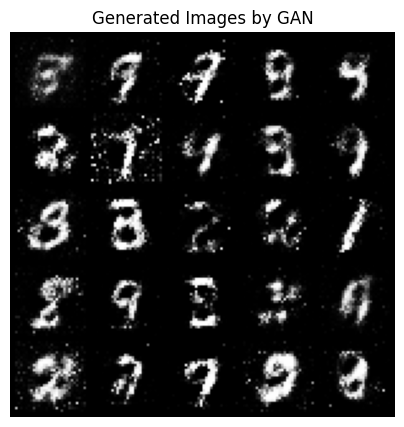

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True
)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop
epochs = 20
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, 100).to(device)
        fake_images = generator(z)

        outputs_real = discriminator(real_images)
        outputs_fake = discriminator(fake_images.detach())

        d_loss_real = criterion(outputs_real, real_labels)
        d_loss_fake = criterion(outputs_fake, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, 100).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)

        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Generate and plot fake images
generator.eval()
z = torch.randn(25, 100).to(device)
fake_images = generator(z).view(-1, 1, 28, 28).cpu().detach()

grid = torchvision.utils.make_grid(fake_images, nrow=5, normalize=True)
plt.figure(figsize=(5,5))
plt.title("Generated Images by GAN")
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()
